# **Problem Statement :**
Farmers face significant economic losses and crop waste each year due to various diseases affecting potato plants, with Early blight and Late blight being the primary culprits. These diseases are responsible for the major reduction in potato yield. Consequently, the images are classified into three classes:

1. Potato Healthy Leaf.
2. Potato Early Blight.
3. Potato Late Blight.

# Methodology
The process involves several steps, including importing libraries, loading and viewing data, splitting the data into training and validation sets, data pre-processing, building the CNN model, training the model, and analyzing the model performance.

**Step 1: Importing Dependencies :** In this step, we import the necessary libraries such as NumPy, and TensorFlow. We also load the potato leaf images from our constructed dataset directory using tf.keras.preprocessing.image_dataset_from_directory. This function automatically loads the images from the directory and creates an image dataset along with their corresponding labels.

**Step 2: Loading and Splitting the Data**

**Step 3: Data Analysis** We check the available classes and visualize a few samples of the loaded data to ensure that the images are correctly loaded and to get an understanding of the dataset structure.

**Step 4: Data Pre-processing :** Data pre-processing involves several steps to prepare the images for training. These steps include resizing and rescaling(normalization ) the images to a consistent size, data augmentation to increase the dataset diversity and generalization.

**Step 5: Model Building :** In this step, we build the CNN model using TensorFlow's Keras API. The model consists of Convolutional layers (Conv2D), MaxPooling layers to reduce the spatial dimensions, and other necessary layers. We optimize the model using the Adam optimizer and use Sparse Categorical Crossentropy as the loss function, as we have multiple classes and integer-encoded labels. We also define accuracy metrics to monitor metrics such as training accuracy, validation accuracy, training loss, and validation loss to analyze the model behavior and identify potential overfitting.

**Step 6: Model Evaluation:**  In this section, we evaluate the model performance by generating confusion matrix and classification report and check test accuracy and run some inferences on test-set.

**Step 7: Save the model with keras/h5 extensions**


# 1. Importing Required Dependencies

In [ ]:
import numpy as np
import os
import seaborn as sns
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Define Constants Parameters

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 50
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
data_dir = "/kaggle/input/my-potato-dataset/dataset"
CHANNELS=3

# 2. Loading the Data and Splitting

## 2.1 Defining a Function to Split Dataset

Divide dataset into 3 subsets:
1. 80% --> Training: Dataset to be used while training
2. 10% --> Validation: Dataset to be tested against while training
3. 10% --> Test: Dataset to be tested against after the model training

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = ds.cardinality().numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


## 2.2 Reading and Partitioning/splitting the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function that we created before (above)

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=150,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 10508 files belonging to 3 classes.


## 2.3 Checking Batch Size

In [86]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)

(32,)


# 3. Data Analysis

## 3.1 Checking the Available Classes

In [12]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## 3.2 Displaying Some Sample Images

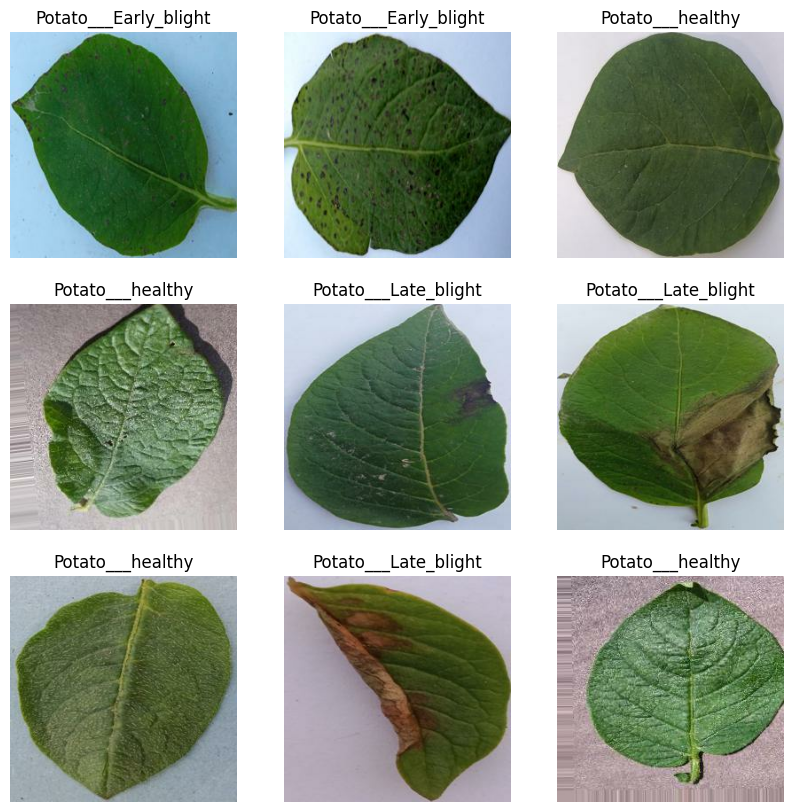

In [56]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
def plot_distribution(y, title):
    a = Counter(y)
    y = class_names
    print()
    x = [a[i] for i in range(3)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='green')
    plt.title(title)
    return plt.show()


## 3.3. Data Distribution for the whole Dataset

In [13]:
import collections
import pandas as pd
class_counts = collections.defaultdict(int)

for images, labels in dataset:
    for i in range(labels.shape[0]):
        class_counts[class_names[labels[i]]] += 1
        
#data = [(i, count) for i, count in class_counts.items()]
#df = pd.DataFrame(data, columns=['Class Name', 'Number of Images'])

df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["Count"])
df.head()

,Count
Potato___healthy,3389
Potato___Early_blight,3628
Potato___Late_blight,3491


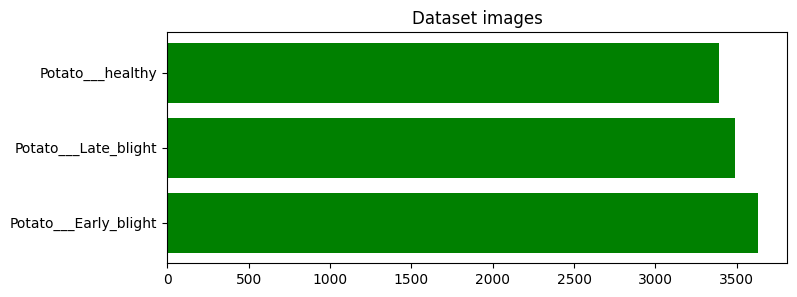

In [15]:
y = np.concatenate([y for x, y in dataset], axis=0)

plot_distribution(y, title="Dataset images")

## 3.3 Data Distribution for each Set


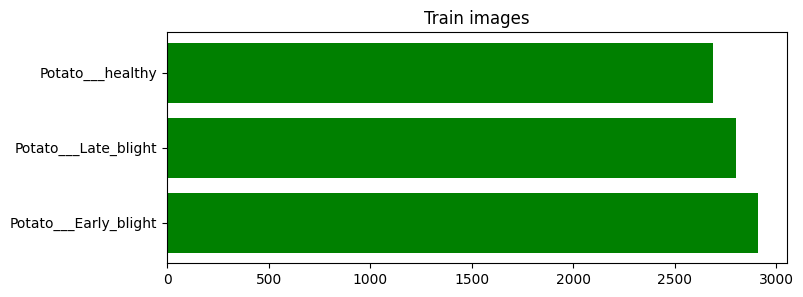

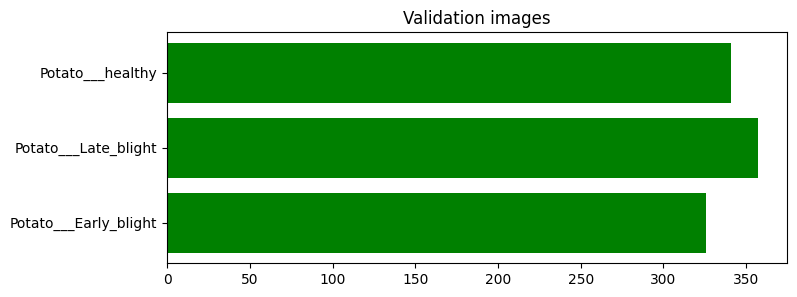

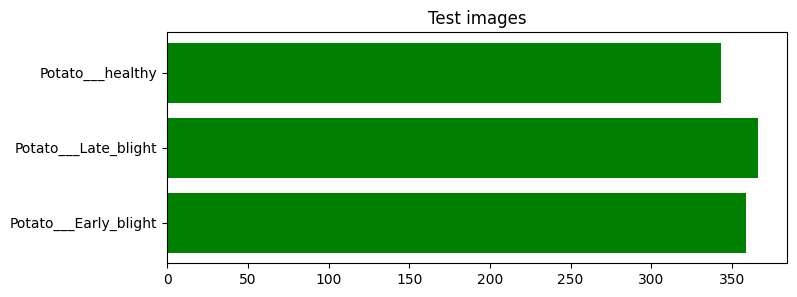

In [16]:

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)
y_test = np.concatenate([y for x, y in test_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")
plot_distribution(y_test, title = "Test images")


# 4. Data Pre-processing / Augmentation

## Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


## Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2)
])


## Cache, Shuffle, and Prefetch the Dataset for optimization purpose

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# 5. Model Building

## 5.1 Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [14]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(


## 5.2 Model Summary

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

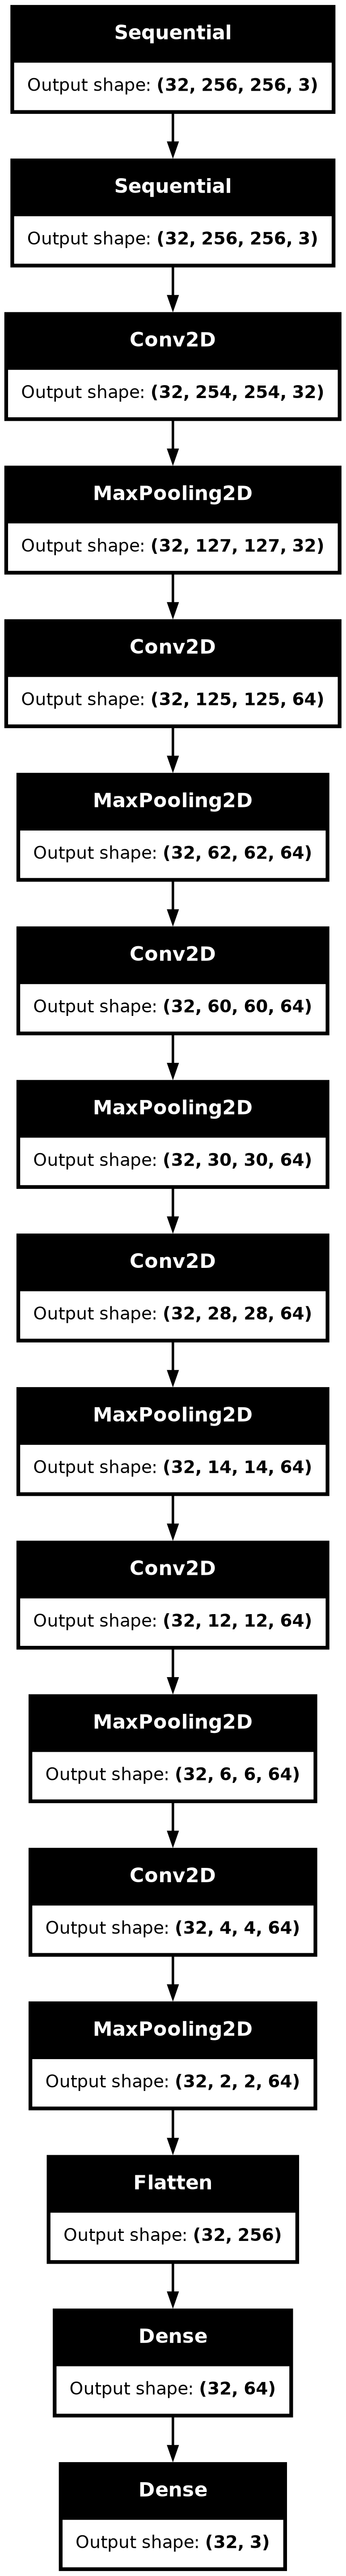

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(model, expand_nested=True, show_shapes=True, show_layer_names=False)

## 5.3 Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## 5.4 Training the CNN

In [37]:
with tf.device('/GPU:0'):
            history = model.fit(
            train_ds,
            batch_size=BATCH_SIZE,
            validation_data=val_ds,
            verbose=1,
            epochs=EPOCHS,)

Epoch 1/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9868 - loss: 0.0411 - val_accuracy: 0.9937 - val_loss: 0.0207

Epoch 2/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9913 - loss: 0.0313 - val_accuracy: 0.9927 - val_loss: 0.0146

Epoch 3/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9851 - loss: 0.0428 - val_accuracy: 0.9844 - val_loss: 0.0603

Epoch 4/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9875 - loss: 0.0380 - val_accuracy: 0.9760 - val_loss: 0.0697

Epoch 5/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9856 - loss: 0.0418 - val_accuracy: 0.9937 - val_loss: 0.0192

Epoch 6/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9915 - loss: 0.0284 - val_accuracy: 0.9823 - val_loss: 0.0483

Epoch 7/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9870 - loss: 0.0429 - val_accuracy: 0.9917 - val_loss: 0.0219

Epoch 8/50

240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9874 - 

# 6. Model Evaluation

## 6.1 Testing the Model on Test-Set

In [70]:
print("[INFO] Calculating model accuracy for test-set")
scores = model.evaluate(test_ds)
print(scores[1])
print(f"Test Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy for test-set

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9985 - loss: 0.0099

0.9979166388511658

Test Accuracy: 99.79166388511658%


In [73]:
print("[INFO] Calculating model accuracy for train-set")
scores = model.evaluate(train_ds)
print(f"Train Accuracy: {scores[1]*100}%")

[INFO] Calculating model accuracy for train-set

240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9946 - loss: 0.0142

Train Accuracy: 99.46614503860474%


## 6.2 Plotting the Accuracy and Loss Curves for Train and Val Sets

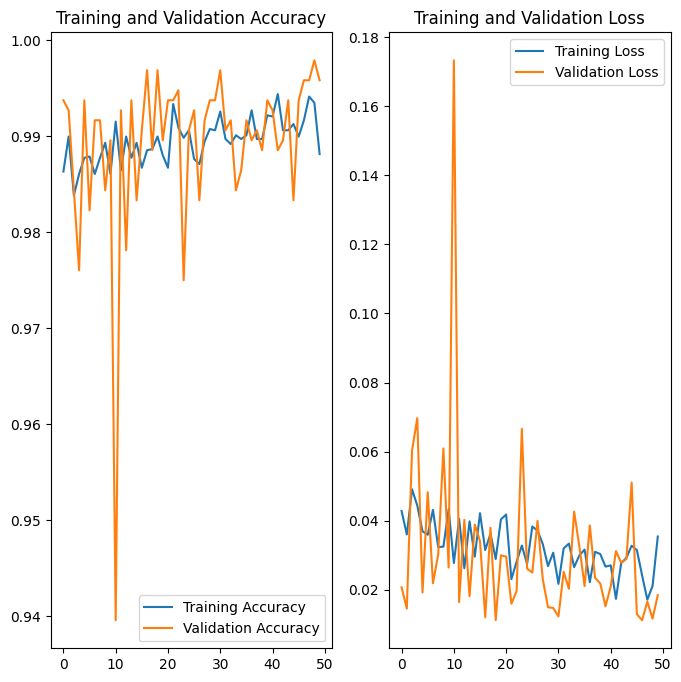

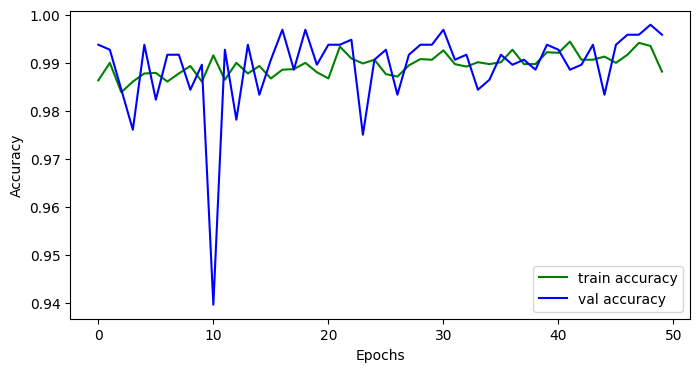

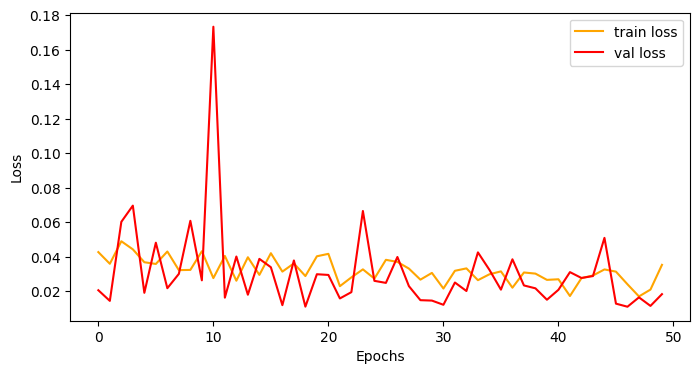

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(acc, color='green', linestyle='-', label='train accuracy')
plt.plot(val_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plots
plt.figure(figsize=(8, 4))
plt.plot(loss, color='orange', linestyle='-', label='train loss')
plt.plot(val_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 6.3 Function for Inference

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## 6.4 Plotting the Inference Data on Test-Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


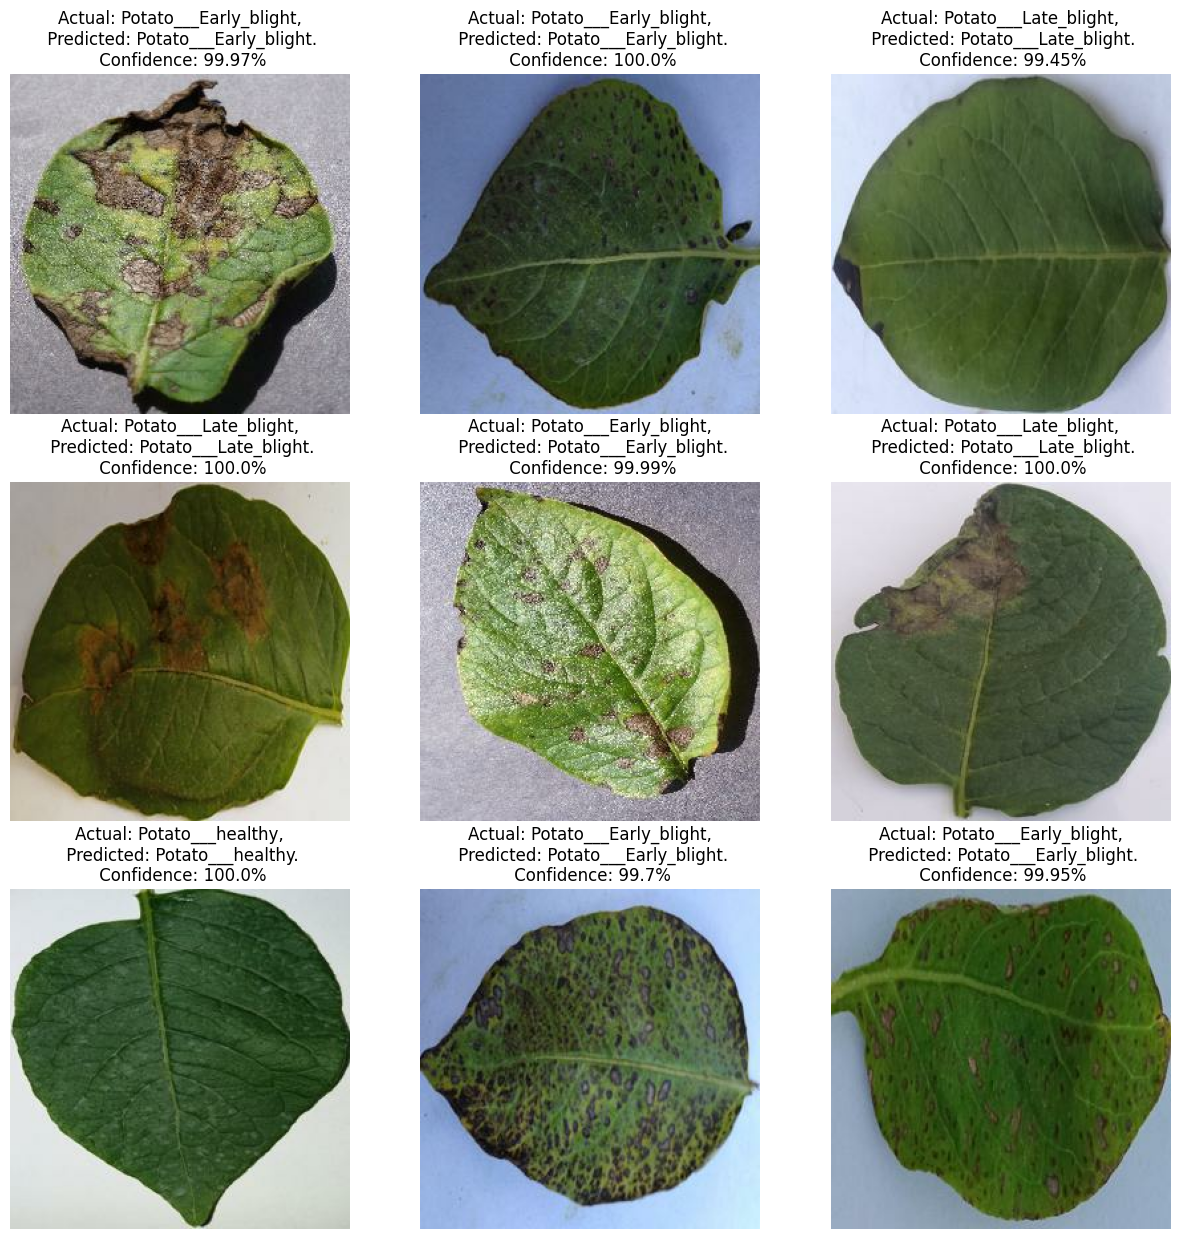

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

## 6.5. Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 

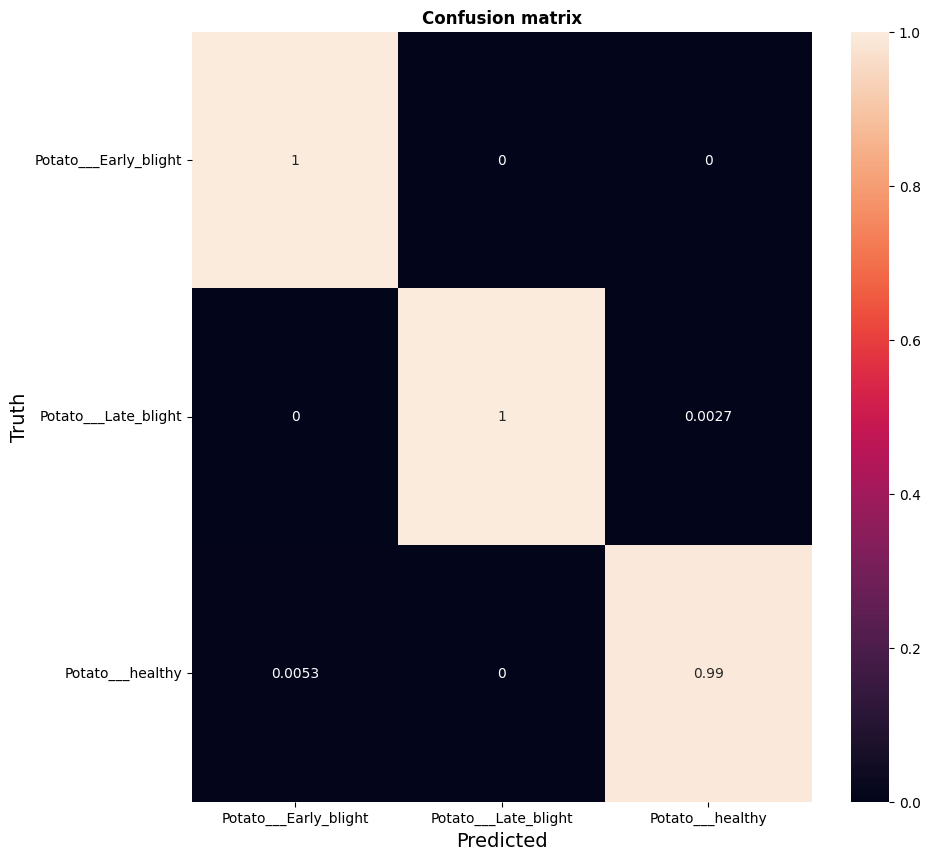

In [63]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# Confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True)

ax.set_yticklabels(class_names, rotation=0, va="center")
ax.set_xticklabels(class_names, rotation=0, ha="center")


plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("Truth", fontsize=14)
plt.xlabel("Predicted", fontsize=14)

plt.show()

## 6.6. Sklearn Report

In [64]:
print(classification_report(correct_labels, predicted_labels,target_names=dataset.class_names))


                       precision    recall  f1-score   support



Potato___Early_blight       1.00      1.00      1.00       406

 Potato___Late_blight       1.00      1.00      1.00       367

     Potato___healthy       0.99      0.99      0.99       187



             accuracy                           1.00       960

            macro avg       1.00      1.00      1.00       960

         weighted avg       1.00      1.00      1.00       960




# 7. Saving the Model

In [120]:
model.save('/kaggle/working/my_model.keras')
model.save('/kaggle/working/my_model.h5')